# Ignore this

In [ ]:
import pandas as pd


class Preprocess():
    def __init__(self):
        sea_ice_data = pd.read_csv('N_seaice_extent_daily_v3.0.csv')
        sea_ice_data = sea_ice_data.drop(index = 0, axis = 0)
        sea_ice_data = sea_ice_data.rename(columns = lambda x: x.strip())
        sea_ice_data = sea_ice_data.drop(columns = ['Month', 'Day', 'Missing', 'Source Data'], axis = 1)
        sea_ice_data = self.sea_ice_averages(sea_ice_data)

        co2_data = pd.read_csv('co2_mm_mlo.csv')
        co2_data = co2_data.rename(columns = lambda x: x.strip())
        co2_data = co2_data.drop(columns = ['month', 'decimal date', 'de-seasonalized', '#days', 'st.dev of days', 'unc. of mon mean'], axis = 1)
        co2_data = self.co2_averages(co2_data)
        co2_data = co2_data.loc[co2_data['year'] > 1977]
        co2_data = co2_data.reset_index()

        celsius_data = pd.read_csv('graph.csv')
        celsius_data = celsius_data.rename(columns = lambda x: x.strip())
        celsius_data = celsius_data.drop(columns = ['Lowess(5)'], axis = 1)
        celsius_data = celsius_data.loc[celsius_data['Year'] > 1977]
        celsius_data = celsius_data.append(pd.DataFrame({'Year': [2022],
                                          'No_Smoothing': [0.84] #interpolated as 2021 value, assuming the data follows a trend
                                         }))
        celsius_data = celsius_data.reset_index()                             

        all_data = sea_ice_data
        all_data['Global CO2'] = co2_data['monthly average']
        all_data['Temp Diff From Average'] = celsius_data['No_Smoothing']
        sea_ice_data.to_csv('sea_avg_multi.csv', index=False) #SEA ICE DATA TO A CSV
        
        #min max normalisation
        all_data['Extent'] = (all_data['Extent'] - all_data['Extent'].min()) / (all_data['Extent'].max() - all_data['Extent'].min()) 
        all_data['Global CO2'] = (all_data['Global CO2'] - all_data['Global CO2'].min()) / (all_data['Global CO2'].max() - all_data['Global CO2'].min())
        all_data['Temp Diff From Average'] = (all_data['Temp Diff From Average'] - all_data['Temp Diff From Average'].min()) / (all_data['Temp Diff From Average'].max() - all_data['Temp Diff From Average'].min()) 
        
        print(sea_ice_data.head())
        print(all_data.head())
    
    def sea_ice_averages(self, sea_ice_data):
        sea_ice_data['Year'] = pd.to_numeric(sea_ice_data['Year'])
        sea_ice_data['Extent'] = pd.to_numeric(sea_ice_data['Extent'])
        
        unique_vals = pd.unique(sea_ice_data['Year'])

        yearly_averages = []
        for i in unique_vals:
            x = 0
            y = 0
            for index, row in sea_ice_data.iterrows():
                if row['Year'] == i:
                    x += row['Extent']
                    y += 1
                    sea_ice_data = sea_ice_data.drop(index, axis = 0)
                else:
                    break
            yearly_averages.append(x / y)

        sea_ice_data['Year'] = unique_vals
        sea_ice_data['Extent'] = yearly_averages
        sea_ice_data.to_csv('sea_avg.csv', index=False) #SEA ICE DATA TO A CSV
        return sea_ice_data

    def co2_averages(self, co2_data):
        co2_data['year'] = pd.to_numeric(co2_data['year'])
        co2_data['monthly average'] = pd.to_numeric(co2_data['monthly average'])
        
        unique_vals = pd.unique(co2_data['year'])

        yearly_averages = []
        for i in unique_vals:
            x = 0
            y = 0
            for index, row in co2_data.iterrows():
                if row['year'] == i:
                    x += row['monthly average']
                    y += 1
                    co2_data = co2_data.drop(index, axis = 0)
                else:
                    break
            yearly_averages.append(x / y)

        co2_data['year'] = unique_vals
        co2_data['monthly average'] = yearly_averages
        return co2_data

def main():
    df = Preprocess()
if __name__ == '__main__':
    main()

# Start reading code from here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('sea_avg_multi.csv')
df.head()

,Year,Extent,Global CO2,Temp Diff From Average
0,1978,12.487000,335.415000,0.07
1,1979,12.319560,336.835000,0.16
2,1980,12.334148,338.762500,0.26
3,1981,12.135486,340.120000,0.32
4,1982,12.439445,341.478333,0.14


In [3]:
#Splitting X and Y
y = df['Extent'].to_numpy()
X = df.drop(['Extent'],axis=1)
print(X.head())

#Z normalisation
u = np.mean(X,axis=0)
std = np.std(X,axis=0)
print(u.shape, std.shape)

X = (X-u)/std
print(X.head())
print(type(X))

ones = np.ones((X.shape[0],1))
X = np.hstack((ones,X))
print(X.shape)
print(type(X))

#Just to see if X is right, we dont need a dataframe after we got numpy array for X and y
#df = pd.DataFrame(X)
#df.head()

   Year  Global CO2  Temp Diff From Average
0  1978  335.415000                    0.07
1  1979  336.835000                    0.16
2  1980  338.762500                    0.26
3  1981  340.120000                    0.32
4  1982  341.478333                    0.14
(3,) (3,)
       Year  Global CO2  Temp Diff From Average
0 -1.693979   -1.540209               -1.708614
1 -1.616980   -1.481698               -1.361578
2 -1.539981   -1.402275               -0.975984
3 -1.462982   -1.346340               -0.744627
4 -1.385983   -1.290370               -1.438697
<class 'pandas.core.frame.DataFrame'>
(45, 4)
<class 'numpy.ndarray'>


In [4]:
#vectorised stuff instead of running loops and storing values in list
def hypothesis(X,theta):
    return np.dot(X,theta)

def error(X,y,theta):
    e = 0.0
    m = X.shape[0]
    y_hat = hypothesis(X,theta)
    e = np.sum((y-y_hat)**2)
    
    return e/m

def gradient(X,y,theta):
    y_hat = hypothesis(X,theta)
    grad = np.dot(X.T,(y_hat-y))
    m = X.shape[0]
    
    return grad/m

def gradient_descent(X,y,learning_rate,max_epochs):
    n = X.shape[1]
    theta = np.zeros((n,))
    error_list = []
    
    for i in range(max_epochs):
        e = error(X,y,theta)
        error_list.append(e)
        
        grad = gradient(X,y,theta)
        theta = theta - learning_rate*grad
        
    return theta,error_list

In [5]:
learning_rate = 0.1
epochs = 100
theta, error_list = gradient_descent(X,y,learning_rate,epochs)

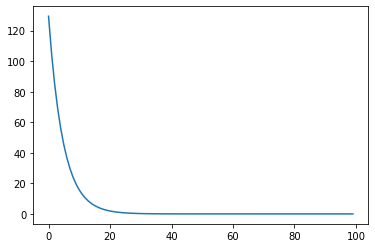

In [6]:
#Plotting error
plt.plot(error_list)
plt.show()

In [7]:
y_hat = hypothesis(X,theta)
y_hat

array([12.48639807, 12.37362651, 12.24709993, 12.16231418, 12.29685963,
       12.10865582, 12.21254749, 12.21800081, 12.13413217, 11.97308801,
       11.8698783 , 11.94816411, 11.75470945, 11.77141656, 11.91066128,
       11.87783174, 11.77125088, 11.61656418, 11.6924852 , 11.53661781,
       11.36412108, 11.53211541, 11.49475335, 11.33454293, 11.21528335,
       11.18379952, 11.2237098 , 11.05737517, 11.05715905, 10.99454566,
       11.07018624, 10.93557409, 10.83162917, 10.89864604, 10.8244302 ,
       10.76415714, 10.66370635, 10.4798666 , 10.33080799, 10.37411973,
       10.40269285, 10.23954746, 10.16188297, 10.28865946, 10.25183383])

In [8]:
def r2_score(y,y_hat):
    num = np.sum((y-y_hat)**2)
    denom = np.sum((y-y.mean())**2)
    score = (1-num/denom)
    return score*100

r2_score(y,y_hat)

90.54780086649804

[-1.69397911 -1.61698006 -1.53998101 -1.46298196 -1.38598291 -1.30898386
 -1.23198481 -1.15498576 -1.0779867  -1.00098765 -0.9239886  -0.84698955
 -0.7699905  -0.69299145 -0.6159924  -0.53899335 -0.4619943  -0.38499525
 -0.3079962  -0.23099715 -0.1539981  -0.07699905  0.          0.07699905
  0.1539981   0.23099715  0.3079962   0.38499525  0.4619943   0.53899335
  0.6159924   0.69299145  0.7699905   0.84698955  0.9239886   1.00098765
  1.0779867   1.15498576  1.23198481  1.30898386  1.38598291  1.46298196
  1.53998101  1.61698006  1.69397911]


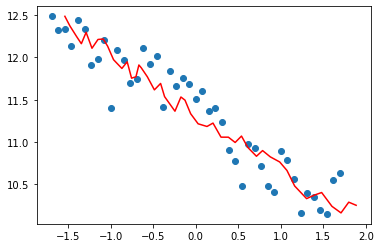

In [9]:
import matplotlib.pyplot as plt
#x = df2['Year'].to_numpy()
print(X[:,1])
plt.scatter(X[:,1],y)
plt.plot(X[:,2],y_hat,c="red")
plt.show()